<a href="https://colab.research.google.com/github/theandeepsuthar/OIBSIP/blob/main/Oasis_task4_Email_spam_detection_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
df = pd.read_csv('/content/spam.csv',delimiter=',',encoding='latin-1')
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns = {'v1':'spam','v2':'text'})
df['spam'].replace(['ham','spam'],[0,1],inplace=True)
df.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['spam'], test_size=0.1, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train_cv = vectorizer.transform(X_train)
X_test_cv  = vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train_cv, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test_cv)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_cv, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[491   0]
 [  8  59]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       491
           1       1.00      0.88      0.94        67

    accuracy                           0.99       558
   macro avg       0.99      0.94      0.96       558
weighted avg       0.99      0.99      0.99       558



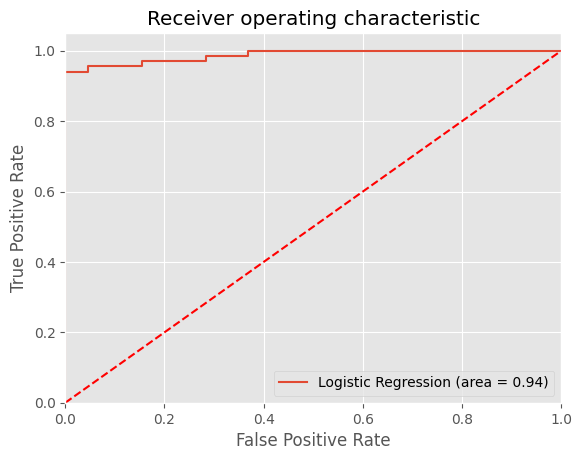

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_cv)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_emb = tokenizer.texts_to_sequences(X_train)
X_test_emb = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[0])
print(X_train_emb[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
[2772, 174, 12, 13, 2166, 15, 4, 397, 4115, 46, 2772, 739, 109, 880, 4116, 101, 3, 30, 28, 322, 170, 24, 68, 4, 397, 8, 4, 4117, 4118]


In [ ]:
from keras.utils import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train_emb, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test_emb, padding='post', maxlen=maxlen)

print(X_train[0, :])

[2772  174   12   13 2166   15    4  397 4115   46 2772  739  109  880
 4116  101    3   30   28  322  170   24   68    4  397    8    4 4117
 4118    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
import keras
import tensorflow as tf

embedding_dim = 50
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, embedding_dim))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          422300    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 423,133
Trainable params: 423,133
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=16)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 1.0000
Testing Accuracy:  0.9875


In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000],
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV



In [ ]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
df = pd.read_csv('/content/spam.csv',delimiter=',',encoding='latin-1')
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns = {'v1':'spam','v2':'text'})
df['spam'].replace(['ham','spam'],[0,1],inplace=True)



In [ ]:
# Run grid search for each source (yelp, amazon, imdb)

sentences = df['text'].values
y = df['spam'].values

# Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.20, random_state=1000)



In [ ]:
# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)



In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



In [ ]:
# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)



<ipython-input-26-96b576239443>:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


In [ ]:
grid_result = grid.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


In [31]:

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

In [32]:
print(test_accuracy)
print(grid.best_score_)
print(grid.best_params_)

0.9856502413749695
0.9874346852302551
{'vocab_size': 7901, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50}
